# Simple Fixed Income Market

by Thomas Krabichler

## Packages

In [5]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.integrate
import scipy.signal
from scipy.special import softmax

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DDPG
from stable_baselines3 import DQN
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

## Model Parameters

In [6]:
# TIME GRID

N=12*20
time_grid_plain=np.linspace(0,N,N+1)
time_grid_dcc=time_grid_plain/12 # day-count-convention

# BALANCE SHEET PARAMETERS

# assets
A0=100
# liabilities (constant deposits)
L0=50

# control the total swap volume
penalty=0.1

## Objective

In [7]:
# OPTIMISATION PARAMETERS
target_month=120

# loss function
target_equity=70

# size of training and validation set
nScenarios=10**3
nValidation=10**3

## Term Structure Model

In this section, we rely on historical ECB yield curve data. The mathematical framework of the Svensson parameterisation and the principal component analysis can be found in the Sections 3.3.3 - 3.4 of the textbook «Term Structure Models» by Damir Filipovic. Please be aware of Proposition 9.5 in the same book.

In [8]:
# YIELD CURVE PARAMETERS

index_yc=2135 # 31-Dec-2012

# YIELD CURVE DYNAMICS

# data import
path=''
ECB=pd.read_csv('201231_ECB.csv')

# zero-coupon bond prices for maturity T in years and Svensson parameter z
def ZCB_prices(T,z):
    return np.exp(-1/100*(z[0]*T-(z[1]/z[4]+z[2]/z[4]**2)*(np.exp(-z[4]*T)-1)-\
        z[2]/z[4]*T*np.exp(-z[4]*T)-z[3]/z[5]*T*np.exp(-z[5]*T)-z[3]/z[5]**2*\
        (np.exp(-z[5]*T)-1)))

# historical discount factors for a time grid
vec_ZCB_prices=np.vectorize(ZCB_prices,excluded=[1])

# yields for historical day i
def hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    shift=0 if rating=='AAA' else 6
    z=[ECB.loc[i,:][1+shift],ECB.loc[i,:][2+shift],ECB.loc[i,:][3+shift]/\
        ECB.loc[i,:][5+shift],ECB.loc[i,:][4+shift]/ECB.loc[i,:][6+shift],1/\
        ECB.loc[i,:][5+shift],1/ECB.loc[i,:][6+shift]]
    return np.divide(-np.log(vec_ZCB_prices(grid,z)),grid)

# collection of historical yields
def vec_hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    output=hist_yc(i[0],grid,rating)
    for j in i[1:]:
        output=np.vstack((output,hist_yc(j,grid,rating)))
    return output

# transform yields into discount factors
def discounting(yields,terms):
    return np.exp(-yields*terms)

# PCA
hist_increments=vec_hist_yc(range(1,index_yc))-vec_hist_yc(range(0,index_yc-1))
PCA_mu=np.mean(hist_increments,axis=0)
PCA_Q=np.cov(hist_increments,rowvar=False)
PCA_lambda,PCA_Lambda=np.linalg.eig(PCA_Q)
PCA_lambda,PCA_Lambda=np.real(PCA_lambda),np.real(PCA_Lambda)
#print(np.cumsum(PCA_lambda)[:10]/np.sum(PCA_lambda))

# generate a new yield curve increment
def yc_scn_gen(n = 3,PCA_mu=PCA_mu,PCA_Lambda=PCA_Lambda,PCA_lambda=PCA_lambda):
    return 22*PCA_mu+np.matmul(PCA_Lambda[:,:n],np.random.multivariate_normal(\
        np.zeros(n),np.diag(22*PCA_lambda[:n])).reshape(n,1)).flatten()

# YIELD CURVE OBJECTS

class yc:
    def __init__(self,yields):
        self.yields=yields
        self.dfs=discounting(yields,time_grid_dcc[1:])
    
    def cpn(self,tenor,maturity):
        return 12/tenor*(1-self.dfs[maturity-1])/np.sum(self.dfs[np.arange(\
            tenor,maturity+tenor,tenor)-1])
    
    def pv(self,cash_flows):
        return np.dot(self.dfs,cash_flows)
    
    def update(self,new_yields):
        self.yields=new_yields
        self.dfs=discounting(new_yields,time_grid_dcc[1:])

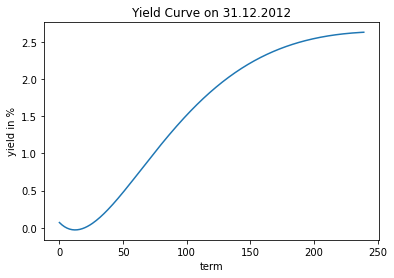

In [9]:
Y = yc(hist_yc(index_yc))
plt.plot(100*Y.yields)
plt.title('Yield Curve on '+ ECB.iloc[index_yc-1,0])
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

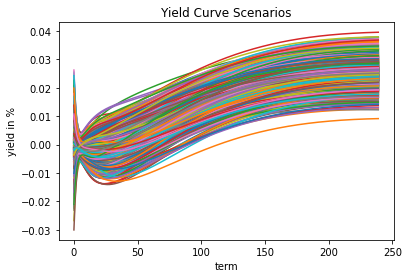

In [10]:
for k in range(int(1e3)):
    plt.plot(Y.yields+target_month*PCA_mu+np.matmul(PCA_Lambda[:,:3], np.random.multivariate_normal(np.zeros(3),np.diag(target_month*\
        PCA_lambda[:3])).reshape(3,1)).flatten())
plt.title('Yield Curve Scenarios')
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

## Swap Market

For simplicity, swap tenors in either legs are $1m$. The fixed leg is chosen such that swaps trade at par at issuance. E.g., see the section «Valuation of Interest Rate Swaps» in the textbook «Options, Futures,
and other Derivatives» by John C. Hull for further details.

In [11]:
swap_series=[24,60,120,240] # In this model we can only receive fixed and pay floating 

class swap:
    def __init__(self, yc, nominal, maturity, month_acquired=1): #tenor=1, month_index
        self.yc = yc
        self.nominal = nominal
        self.maturity = maturity
        self.fixed_leg = np.repeat(yc.cpn(1,self.maturity), self.maturity)
        self.month_acquired = month_acquired
        
    #def update(self, steps = 1):
    #    self.cash_flows = np.append(self.cash_flows[steps:],np.zeros(steps))

def swap_indicator(maturity):
    return np.reshape(np.append(np.ones(maturity),np.zeros(N-maturity)),(1,N))

In [12]:
Y = yc(hist_yc(index_yc))
s = swap(Y, nominal = 100, maturity = 24)
s1 = swap(Y, nominal = 100, maturity = 12)
s1.fixed_leg

array([-0.00027614, -0.00027614, -0.00027614, -0.00027614, -0.00027614,
       -0.00027614, -0.00027614, -0.00027614, -0.00027614, -0.00027614,
       -0.00027614, -0.00027614])

In [9]:
# some utilites that will be needed later:
def discount_cumsum(x, discount):
    """
    Compute  cumulative sums of vectors.

    Input: [x0, x1, ..., xn]
    Output: [x0 + discount * x1 + discount^2 * x2, x1 + discount * x2, ..., xn]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1][0]

## Benchmark Strategy of a Retail Bank

For the time being (and this can be relaxed), the deposits of the clients are kept constant and bear no interest. The asset side earns the monthly short rate. However, one could do better, if one incorporated swaps into the ecosystem. The current benchmark follows the strategy «doing nothing».

In [58]:
def benchmark(nRoutines=nValidation):
    output=np.zeros(nRoutines)
    for l in range(nRoutines):
        # yield curve
        Y=yc(hist_yc(index_yc))
        # assets
        A_pre=A0
        A_post=A0
        L=L0
        E=(A0-L0)
        for k in range(target_month):
            # market updates
            A_pre*=np.exp(Y.yields[0]/12)
            Y=yc(Y.yields+yc_scn_gen())
            A_post=A_pre
            L=L
            E=A_post-L
        output[l]=E
    return output

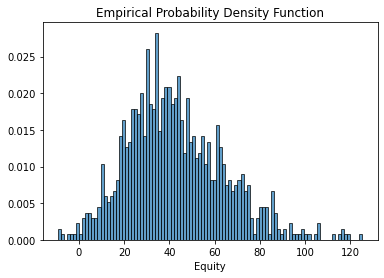

In [13]:
plt.hist(benchmark(), bins=100, density=True, edgecolor='black', alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

I decided to tackle this problem using the Reinforcement Learning methodology. To proceed, it is usually useful to construct a "gym" environment https://gym.openai.com/docs/ from our given ALM environment setup. 


In [21]:
class ALMgym(gym.Env):

    def __init__(self, begin_index_yc, A0, L0, swaps_no, target_month):
        
        super(ALMgym, self).__init__()
        
        self.Y  = yc(hist_yc(begin_index_yc))
        self.begin_index_yc = begin_index_yc
        self.current_month = 0
        self.target_month = target_month
        
        self.A0 = A0
        self.L0 = L0
        
        self.swaps_no = swaps_no
        self.swaps = []
        self.swap_cash_flow = np.zeros(target_month)
        
        self.epsilon = 0.5
        self.discount_gamma = 0.95
        
        # We will assume we can move any part of Assets and Liabilities with no transaction cost
        
        l = [A0, L0]
        l.extend([0 for i in range(swaps_no)])
        l.extend(self.Y.yields.tolist())
        
        self.initial_state = np.array(l, dtype = np.single)  # Initially no money is invested in any swap
        
        self.state = np.copy(self.initial_state)             # States and observations are synonmous in our model (full observability)
        
        #self.action_space = spaces.Box(low = 0, high = (self.A0 + self.L0)/4, shape = (swaps_no,), dtype = np.single) 
        #self.action_space = spaces.MultiDiscrete([(4), (self.A0 + self.L0)]) 
        
        self.action_space = spaces.Discrete(2*10)
        self.observation_space = spaces.Box(low = -10 , high = 1000, shape = (2 + swaps_no + 240,), dtype=np.single)
        
        # In theory the assets accrued can go to infinity but actually we cap it at 1000 - I will explain this later
        # Position 1 in the observations = state array is assets other than swaps, position 2 in the array is liabilities, 
        # and the rest are the notional invested in each swap
        # We receive interest on assets but don't pay any interest on liabilities

    def step(self, action):
        
        done   = False
        reward = 0
        info   = dict()
        
        self.current_month += 1
                                 
        self.Y = yc(self.Y.yields + yc_scn_gen())    # update the yield curve
        
        self.state[0] *= np.exp(Y.yields[0]/12)      # Update the earnings due to interest on assets 
        self.state[(2 + 4)::] = self.Y.yields
        
        # and collect the fixed rate due TODO
        # Then pay floating for existing swaps
        
        for swp in self.swaps:
            
            # if the swap is still active - pay floating, TODO check if inequality should be <= or < 
            if self.current_month < swp.month_acquired + swp.maturity:
                
                floating_owed = self.Y.cpn(tenor = 1, maturity = 1) * swp.nominal
                
                self.state[0] -= floating_owed                
                
            else:
                
                # If the swap has expired then we can release the nominal and add it back to the assets
                swp_index = swap_series.index(swp.maturity)

                self.state[2 + swp_index] -= swp.nominal
                
                self.state[0] += swp.nominal 
                                    
                self.swaps.remove(swp)

        
        # Now enter new swaps agreements determined by the action
        # In this simplified easy scenario, we can only invest in mutiples of 5, up to 20. 
        
        if self.current_month != self.target_month:
            
            self.state[0] += self.swap_cash_flow[self.current_month] 
            
        swap_index = action // 5
        nominal = (action % 5) * 10
        swap_maturity = np.array(swap_series)[int(swap_index)]
        
        if nominal > 0 and self.current_month != self.target_month:
            
            if self.current_month + swap_maturity < self.target_month:
            
                self.buy_swap(swap_index, swap_maturity, nominal)

        done = self.is_game_over()
        
        if done:

            return np.copy(self.state), -1000, done, info 
        
        elif self.current_month == self.target_month:
            
            # Value the remaining swaps and add it to the assets:
            #for swp in self.swaps:

                #self.state[0] += self.compute_swap_valuation(swp)
                
            if self.is_game_over():
                
                return np.copy(self.state), -1000, True, info 
            
            else:
                
                return np.copy(self.state), 100 * (max(self.state[0] - self.state[1] - 55, 0)), True, info  

        else:
            
            reward = max(0.01*(self.state[0] - self.state[1] - 55), 0)
            
            return np.copy(self.state), float(reward), done, info 
        
        
    def buy_swap(self, swap_index, swap_maturity, nominal):
            
        new_swap = swap(self.Y, nominal = nominal, maturity = swap_maturity, month_acquired = self.current_month - 1)

        # No transaction cost modeled yet - we use assets or liabilities to invest the nominal in the swap,
        # Which is then locked in and can't be further lent out to get interest on

        self.state[0] -= nominal
        
        self.swaps.append(new_swap) 

        maturity_end_month = min(self.current_month + new_swap.maturity, self.target_month)

        self.swap_cash_flow[self.current_month:maturity_end_month] += new_swap.fixed_leg[0:(maturity_end_month - self.current_month)] * new_swap.nominal

        # Finally update the state by incremenenting by the nominal invested in the new swap, 
        # representing that it has been locked in and can't be used by the agent to invest in new swaps
        self.state[2 + swap_index] = self.state[2 + swap_index] + nominal
                
        
    # If at any point the liabilities drop to below 10% of the initial value, the game is over
    def is_game_over(self):
        
        if self.state[0] < 10:
                    
            done = True
        
        else:
            
            done = False
        
        return done
    
    def sample_action(self):
        
        #rates = [self.Y.cpn(1, min(maturity, self.target_month - self.current_month)) for maturity in swap_series]
        rates = [self.Y.cpn(1, maturity) for maturity in swap_series]
        soft_dist = softmax(rates)
        sample = np.random.multinomial(1, soft_dist)
        swap_index = np.where(sample == 1)[0][0]
        action = swap_index * 5 + np.random.randint(5, size=1)[0]
        return action
        
    
    # Reset the state of the environment to the initial state
    def reset(self):
        
        self.Y  = yc(hist_yc(self.begin_index_yc))
        self.state = np.copy(self.initial_state)
        self.swap_cash_flow = np.zeros(self.target_month)
        self.current_month = 0
        self.swaps = []
        return self.state


First we test whether the env is set up correctly by initiating a random agent

In [22]:
target_month = 120
env = ALMgym(index_yc, A0, L0, len(swap_series), target_month)

state  = np.copy(env.initial_state)
output = np.zeros(1000)

In [23]:
check_env(env) # Very useful method checking whether your custom envirnoment fits the stable_baselines3 blueprint

In [24]:
env.reset()
print(state)

for k in range(target_month):
    
    action = env.action_space.sample()   # just take random action = investing arbitrary nominal in arbitrary swap
    next_state, reward, done, info = env.step(action)

    if done:
        
        print("You have lost the game in month " , k)
        print("--------")
        print("Final Legal State", state[0:6])
        print("Reward", reward)
        print("Last Action Attempted", action)
        print("End State", next_state[0:6])
        #print("Liquidable", env.action_space.high)
        print("--------")
        break
        
    else:
        
        print("--------")
        print("State", state[0:6])
        print("Action", action)
        print("Reward", reward)
        print("Next State", next_state[0:6])
        #print("Liquidable", env.action_space.high)
        print("--------")
        state = next_state
    

[ 1.0000000e+02  5.0000000e+01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  7.0633000e-04  5.4102385e-04
  3.9251256e-04  2.6023577e-04  1.4364773e-04  4.2216954e-05
 -4.4574139e-05 -1.1722952e-04 -1.7623989e-04 -2.2208296e-04
 -2.5522383e-04 -2.7611514e-04 -2.8519757e-04 -2.8289994e-04
 -2.6963963e-04 -2.4582265e-04 -2.1184421e-04 -1.6808869e-04
 -1.1493008e-04 -5.2732146e-05  1.8151308e-05  9.7376193e-05
  1.8460791e-04  2.7952113e-04  3.8179953e-04  4.9113564e-04
  6.0723058e-04  7.2979392e-04  8.5854332e-04  9.9320454e-04
  1.1335111e-03  1.2792040e-03  1.4300320e-03  1.5857507e-03
  1.7461232e-03  1.9109191e-03  2.0799150e-03  2.2528938e-03
  2.4296450e-03  2.6099642e-03  2.7936534e-03  2.9805203e-03
  3.1703780e-03  3.3630461e-03  3.5583489e-03  3.7561164e-03
  3.9561843e-03  4.1583921e-03  4.3625855e-03  4.5686150e-03
  4.7763349e-03  4.9856044e-03  5.1962882e-03  5.4082540e-03
  5.6213751e-03  5.8355271e-03  6.0505914e-03  6.2664528e-03
  6.4829993e-03  6.70012

In [25]:
env.reset()

from stable_baselines3 import PPO
# DDPG hyper-params
#n_actions = env.action_space.shape[-1]
#action_noise = OrnsteinUhlenbeckActionNoise(mean=np.repeat(0, n_actions), sigma=10 * np.ones(n_actions))

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps = 1_000_000, log_interval = 1000)
model.save("DQN_ALM_4")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | -1e+03   |
|    exploration rate | 0.9      |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1326     |
|    time_elapsed     | 7        |
|    total timesteps  | 10550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.7     |
|    n_updates        | 237500   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | -1e+03   |
|    exploration rate | 0.801    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 1290     |
|    time_elapsed     | 16       |
|    total timesteps  | 20929    |
-------------------------------

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 65.3     |
|    ep_rew_mean      | 3.33e+04 |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 18000    |
|    fps              | 616      |
|    time_elapsed     | 1348     |
|    total timesteps  | 830959   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 195239   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 64.3     |
|    ep_rew_mean      | 2.27e+04 |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 19000    |
|    fps              | 614      |
|    time_elapsed     | 1461     |
|    total timesteps  | 897861   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.2      |
|    n_updates      

In [26]:
env.reset()
state  = np.copy(env.initial_state)
print("initial state", state)

for k in range(target_month):
    
    action, _states = model.predict(state, deterministic = True)

    next_state, reward, done, info = env.step(action)
    
    if done and k == target_month - 1:
        
        print("You have won the game!")
        print("--------")
        print("Final State", state[0:6])
        print("Action", action)
        print("Reward", reward)
        print("--------")
        break
        
    
    elif done:
        
        print("You have lost the game in month " , k)
        break
        
    else:
        
        print("--------")
        print("State", state[0:6])
        print("Action", action)
        print("Next State", next_state[0:6])
        print("Reward", reward)
        print("--------")
        state = next_state

        

    
    

initial state [ 1.0000000e+02  5.0000000e+01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  7.0633000e-04  5.4102385e-04
  3.9251256e-04  2.6023577e-04  1.4364773e-04  4.2216954e-05
 -4.4574139e-05 -1.1722952e-04 -1.7623989e-04 -2.2208296e-04
 -2.5522383e-04 -2.7611514e-04 -2.8519757e-04 -2.8289994e-04
 -2.6963963e-04 -2.4582265e-04 -2.1184421e-04 -1.6808869e-04
 -1.1493008e-04 -5.2732146e-05  1.8151308e-05  9.7376193e-05
  1.8460791e-04  2.7952113e-04  3.8179953e-04  4.9113564e-04
  6.0723058e-04  7.2979392e-04  8.5854332e-04  9.9320454e-04
  1.1335111e-03  1.2792040e-03  1.4300320e-03  1.5857507e-03
  1.7461232e-03  1.9109191e-03  2.0799150e-03  2.2528938e-03
  2.4296450e-03  2.6099642e-03  2.7936534e-03  2.9805203e-03
  3.1703780e-03  3.3630461e-03  3.5583489e-03  3.7561164e-03
  3.9561843e-03  4.1583921e-03  4.3625855e-03  4.5686150e-03
  4.7763349e-03  4.9856044e-03  5.1962882e-03  5.4082540e-03
  5.6213751e-03  5.8355271e-03  6.0505914e-03  6.2664528e-03
  6.482999

--------
State [20.498095 50.       80.       40.        0.        0.      ]
Action 10
Next State [19.408342 50.       80.       40.        0.        0.      ]
Reward 0.0
--------
--------
State [19.408342 50.       80.       40.        0.        0.      ]
Action 10
Next State [18.002207 50.       80.       40.        0.        0.      ]
Reward 0.0
--------
--------
State [18.002207 50.       80.       40.        0.        0.      ]
Action 10
Next State [47.1156 50.     60.     30.      0.      0.    ]
Reward 0.0
--------
--------
State [47.1156 50.     60.     30.      0.      0.    ]
Action 1
Next State [55.827377 50.       50.       30.        0.        0.      ]
Reward 0.0
--------
--------
State [55.827377 50.       50.       30.        0.        0.      ]
Action 10
Next State [64.53833 50.      40.      30.       0.       0.     ]
Reward 0.0
--------
--------
State [64.53833 50.      40.      30.       0.       0.     ]
Action 10
Next State [63.550564 50.       40.       30.     

In [29]:
target_month = 120

def performance(nRoutines=nValidation):
    
    output=np.zeros(nRoutines)
    
    for l in range(nRoutines):
                
        env.reset()
        state  = np.copy(env.initial_state)
        
        for k in range(target_month):
            
            # market updates
            action, _states = model.predict(state, deterministic = True)
            
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            
            if done:
                
                break
            
        E = state[0] - state[1]
            
        output[l] = E
    
    return output

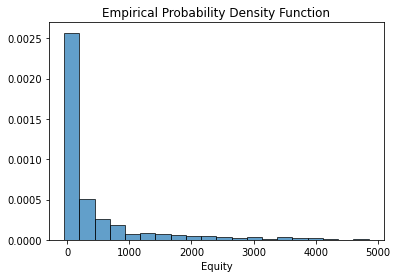

In [32]:
output = performance()
plt.hist(output, bins=20, density=True, edgecolor='black', alpha=0.7)
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()

In [ ]:
def compute_swap_valuation(self, swp):
        
        remaining_duration = swp.month_acquired + swp.maturity - self.current_month
        
        if remaining_duration > 0:
            
            fixed_total = swp.fixed_leg[0:remaining_duration]

            floating_total = np.zeros(remaining_duration)
            counter = 0
            
            yc_fictional = copy.deepcopy(self.Y)
            
            while remaining_duration > 0:
                
                floating_total[counter] = yc_fictional.cpn(tenor = 1, maturity = remaining_duration) * swp.nominal
                yc_fictional = yc(yc_fictional.yields + yc_scn_gen()) 
                remaining_duration -= 1
                counter += 1

            net = fixed_total - floating_total
            swp_value = discount_cumsum(net, self.discount_gamma)

            return swp_value 
    
        else:
            
            return 0

In [ ]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union

import gym
import numpy as np
import torch as th
from torch.nn import functional as F

from stable_baselines3.common import logger
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.preprocessing import maybe_transpose
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_linear_fn, is_vectorized_observation, polyak_update
from stable_baselines3.dqn.policies import DQNPolicy


class CustomDQN(OffPolicyAlgorithm):

    
    
    def __init__(
        self,
        policy: Union[str, Type[DQNPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 1e-4,
        buffer_size: int = 1000000,
        learning_starts: int = 50000,
        batch_size: Optional[int] = 32,
        tau: float = 1.0,
        gamma: float = 0.99,
        train_freq: Union[int, Tuple[int, str]] = 4,
        gradient_steps: int = 1,
        optimize_memory_usage: bool = False,
        target_update_interval: int = 10000,
        exploration_fraction: float = 0.1,
        exploration_initial_eps: float = 1.0,
        exploration_final_eps: float = 0.05,
        max_grad_norm: float = 10,
        tensorboard_log: Optional[str] = None,
        create_eval_env: bool = False,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):

        super(CustomDQN, self).__init__(
            policy,
            env,
            DQNPolicy,
            learning_rate,
            buffer_size,
            learning_starts,
            batch_size,
            tau,
            gamma,
            train_freq,
            gradient_steps,
            action_noise=None,  # No action noise
            policy_kwargs=policy_kwargs,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            create_eval_env=create_eval_env,
            seed=seed,
            sde_support=False,
            optimize_memory_usage=optimize_memory_usage,
            supported_action_spaces=(gym.spaces.Discrete,),
        )

        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.target_update_interval = target_update_interval
        self.max_grad_norm = max_grad_norm
        # "epsilon" for the epsilon-greedy exploration
        self.exploration_rate = 0.0
        # Linear schedule will be defined in `_setup_model()`
        self.exploration_schedule = None
        self.q_net, self.q_net_target = None, None

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super(CustomDQN, self)._setup_model()
        self._create_aliases()
        self.exploration_schedule = get_linear_fn(
            self.exploration_initial_eps, self.exploration_final_eps, self.exploration_fraction
        )

    def _create_aliases(self) -> None:
        self.q_net = self.policy.q_net
        self.q_net_target = self.policy.q_net_target

    def _on_step(self) -> None:
        """
        Update the exploration rate and target network if needed.
        This method is called in ``collect_rollouts()`` after each step in the environment.
        """
        if self.num_timesteps % self.target_update_interval == 0:
            polyak_update(self.q_net.parameters(), self.q_net_target.parameters(), self.tau)

        self.exploration_rate = self.exploration_schedule(self._current_progress_remaining)
        logger.record("rollout/exploration rate", self.exploration_rate)

    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for gradient_step in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Follow greedy policy: use the one with the highest value
                next_q_values, _ = next_q_values.max(dim=1)
                # Avoid potential broadcast issue
                next_q_values = next_q_values.reshape(-1, 1)
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Compute Huber loss (less sensitive to outliers)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        logger.record("train/loss", np.mean(losses))

    def predict(
        self,
        observation: np.ndarray,
        state: Optional[np.ndarray] = None,
        mask: Optional[np.ndarray] = None,
        deterministic: bool = False,
    ) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Overrides the base_class predict function to include epsilon-greedy exploration.

        :param observation: the input observation
        :param state: The last states (can be None, used in recurrent policies)
        :param mask: The last masks (can be None, used in recurrent policies)
        :param deterministic: Whether or not to return deterministic actions.
        :return: the model's action and the next state
            (used in recurrent policies)
        """
        if not deterministic and np.random.rand() < self.exploration_rate:
            if is_vectorized_observation(maybe_transpose(observation, self.observation_space), self.observation_space):
                n_batch = observation.shape[0]
                action = np.array([self.env.env_method("sample_action") for _ in range(n_batch)])
            else:
                action = np.array(self.env.env_method("sample_action"))
        else:
            action, state = self.policy.predict(observation, state, mask, deterministic)
        return action, state

    def learn(
        self,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 4,
        eval_env: Optional[GymEnv] = None,
        eval_freq: int = -1,
        n_eval_episodes: int = 5,
        tb_log_name: str = "DQN",
        eval_log_path: Optional[str] = None,
        reset_num_timesteps: bool = True,
    ) -> OffPolicyAlgorithm:

        return super(CustomDQN, self).learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            eval_env=eval_env,
            eval_freq=eval_freq,
            n_eval_episodes=n_eval_episodes,
            tb_log_name=tb_log_name,
            eval_log_path=eval_log_path,
            reset_num_timesteps=reset_num_timesteps,
        )

    def _excluded_save_params(self) -> List[str]:
        return super(CustomDQN, self)._excluded_save_params() + ["q_net", "q_net_target"]

    def _get_torch_save_params(self) -> Tuple[List[str], List[str]]:
        state_dicts = ["policy", "policy.optimizer"]

        return state_dicts, []
